Plot alpha diversity stratified for lung transplant/controls and swab site

Input file: shannon_dv.txt (alpha diversity)

In [2]:

import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
import matplotlib.patches as mpatches

from matplotlib import transforms, lines, figure
import matplotlib.transforms as mtransforms
from matplotlib.font_manager import FontProperties
from seaborn.utils import remove_na
%matplotlib inline
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
matplotlib.rcParams['font.family'] = "sans-serif"
matplotlib.rcParams['font.sans-serif'] = "Arial"


In [3]:
def setLT_alpha(row):
    """
    Make a column with 'No', 'Yes' which is an snswer to the question 'Did the patient had a lung transplant?'.
    Takes row in DF as input and returns value depending on the row value. 
    """
    
    if row['Lung_Transplant'] == 'yes':
            
        return 'Lung Transplant'

    else:    
        return 'Other'

In [4]:
def setCondition_alpha(row):
    """
    Make a column with 'healthy', 'CF' or 'LT'. Takes row in DF as input and returns value depending on the row 
    value. 
    
    According to instructions; CF with a LT is classified as healthy. 
    """
    
    if row['Lung_Transplant'] == 'yes':
        
        return 'Lung Transplant'
    
    elif row['Cystic_fibrosis'] == 'yes':
        
        return 'Cystic Fibrosis'
        
    return 'Healthy'

In [5]:
import matplotlib.patches as mpatches

class AnyObject:
    pass

class AnyObjectHandler:
    def legend_artist(self, legend, orig_handle, fontsize, handlebox, hatch):
        x0, y0 = handlebox.xdescent, handlebox.ydescent
        width, height = handlebox.width, handlebox.height
        patch = mpatches.Rectangle([x0, y0], width, height, facecolor='white',
                                   edgecolor='black', hatch=hatch, lw=3,
                                   transform=handlebox.get_transform())
        handlebox.add_artist(patch)
        return patch

In [6]:
### Code adapted from https://github.com/webermarcolivier/statannot ###

from matplotlib.text import Text
import matplotlib.pyplot as plt
from matplotlib import transforms, lines
import matplotlib.transforms as mtransforms
from matplotlib.font_manager import FontProperties
from seaborn.utils import remove_na

from scipy import stats
DEFAULT = object()


def stat_test(box_data1, box_data2, test):
    test_short_name = ''
    formatted_output = None
    if test == 'Wilcoxon':
        u_stat, pval = stats.ranksums(box_data1, box_data2)
        test_short_name = 'Wilcox'
        formatted_output = ("Wilcoxon test P_val={:.3e} U_stat={:.3e}"
                           .format(pval, u_stat))
    return pval, u_stat,formatted_output, test_short_name


def pval_annotation_text(x, pvalue_thresholds):
    singleValue = False
    if type(x) is np.array:
        x1 = x
    else:
        x1 = np.array([x])
        singleValue = True
    # Sort the threshold array
    pvalue_thresholds = pd.DataFrame(pvalue_thresholds).sort_values(by=0, ascending=False).values
    x_annot = pd.Series(["" for _ in range(len(x1))])
    for i in range(0, len(pvalue_thresholds)):
        if (i < len(pvalue_thresholds)-1):
            condition = (x1 <= pvalue_thresholds[i][0]) & (pvalue_thresholds[i+1][0] < x1)
            x_annot[condition] = pvalue_thresholds[i][1]
        else:
            condition = x1 < pvalue_thresholds[i][0]
            x_annot[condition] = pvalue_thresholds[i][1]

    return x_annot if not singleValue else x_annot.iloc[0]


def simple_text(pval, pvalue_format, pvalue_thresholds, test_short_name=None):
    """
    Generates simple text for test name and pvalue
    :param pval: pvalue
    :param pvalue_format: format string for pvalue
    :param test_short_name: Short name of test to show
    :param pvalue_thresholds: String to display per pvalue range
    :return: simple annotation
    """
    # Sort thresholds
    thresholds = sorted(pvalue_thresholds, key=lambda x: x[0])

    # Test name if passed
    text = test_short_name and test_short_name + " " or ""

    for threshold in thresholds:
        if pval < threshold[0]:
            pval_text = "p ≤ {}".format(threshold[1])
            break
    else:
        pval_text = "p = {}".format(pvalue_format).format(pval)

    #return text + pval_text
    return pval_text


def add_stat_annotation(ax,
                        data=None, x=None, y=None, hue=None, order=None, hue_order=None,
                        box_pairs=None,
                        test='t-test_welch', text_format='star', pvalue_format_string=DEFAULT,
                        loc='inside', show_test_name=True, pvalue_thresholds=DEFAULT,
                        use_fixed_offset=False, line_offset_to_box=None, line_offset=None,
                        line_height=0.02, text_offset=1, stack=True,
                        color='0.2', linewidth=1.5, fontsize='medium', verbose=1):
    """
    User should use the same argument for the data, x, y, hue, order, hue_order as the seaborn boxplot function.
    line_height is in axes fraction coordinates.
    text_offset is in points.
    box_pairs can be of either form:
    For non-grouped boxplot: [(cat1, cat2), (cat3, cat4)]
    For boxplot grouped by hue: [((cat1, hue1), (cat2, hue2)), ((cat3, hue3), (cat4, hue4))]
    Default pvalue_format_string is "{.3e}".
    pvalue_thresholds is a list of lists or tuples. Default is:
    For "star" text_format:
        [[1e-4, "****"], [1e-3, "***"], [1e-2, "**"], [0.05, "*"], [1, "ns"]]
    For "simple" text_format :
        [[1e-5, "1e-5"], [1e-4, "1e-4"], [1e-3, "0.001"], [1e-2, "0.01"]]
    """

    def find_x_position_box(box_plotter, boxName):
        """
        boxName can be either a name "cat" or a tuple ("cat", "hue")
        """
        if box_plotter.plot_hues is None:
            cat = boxName
            hueOffset = 0
        else:
            cat = boxName[0]
            hue = boxName[1]
            hueOffset = box_plotter.hue_offsets[box_plotter.hue_names.index(hue)]

        groupPos = box_plotter.group_names.index(cat)
        boxPos = groupPos + hueOffset
        return boxPos


    def get_box_data(box_plotter, boxName):
        """
        boxName can be either a name "cat" or a tuple ("cat", "hue")
        Here we really have to duplicate seaborn code, because there is not direct access to the
        box_data in the BoxPlotter class.
        """
        if box_plotter.plot_hues is None:
            cat = boxName
        else:
            cat = boxName[0]
            hue = boxName[1]

        i = box_plotter.group_names.index(cat)
        group_data = box_plotter.plot_data[i]

        if box_plotter.plot_hues is None:
            # Draw a single box or a set of boxes
            # with a single level of grouping
            box_data = remove_na(group_data)
        else:
            hue_level = hue
            hue_mask = box_plotter.plot_hues[i] == hue_level
            box_data = remove_na(group_data[hue_mask])

        return box_data

    # Set default values if necessary
    if pvalue_format_string is DEFAULT:
        pvalue_format_string = '{:.3e}'
        simple_format_string = '{:.2f}'
    else:
        simple_format_string = pvalue_format_string

    if pvalue_thresholds is DEFAULT:
        if text_format == "star":
            pvalue_thresholds = [[1e-4, "****"], [1e-3, "***"],
                                 [1e-2, "**"], [0.05, "*"], [1, "ns"]]
        else:
            pvalue_thresholds = [[1e-5, "1e-5"], [1e-4, "1e-4"],
                                 [1e-3, "0.001"], [1e-2, "0.01"]]
    
    fig = plt.gcf()

    valid_list = ['inside', 'outside']
    if loc not in valid_list:
        raise ValueError("loc value should be one of the following: {}.".format(', '.join(valid_list)))
    valid_list = ['Wilcoxon']
    if test not in valid_list:
        raise ValueError("test value should be one of the following: {}.".format(', '.join(valid_list)))

    if verbose >= 1 and text_format == 'star':
        print("pvalue annotation legend:")
        pvalue_thresholds = pd.DataFrame(pvalue_thresholds).sort_values(by=0, ascending=False).values
        for i in range(0, len(pvalue_thresholds)):
            if (i < len(pvalue_thresholds)-1):
                print('{}: {:.2e} < p <= {:.2e}'.format(pvalue_thresholds[i][1], pvalue_thresholds[i+1][0], pvalue_thresholds[i][0]))
            else:
                print('{}: p <= {:.2e}'.format(pvalue_thresholds[i][1], pvalue_thresholds[i][0]))
        print()

    # Create the same BoxPlotter object as seaborn's boxplot
    box_plotter = sns.categorical._BoxPlotter(x, y, hue, data, order, hue_order,
                                              orient=None, width=.8, color=None, palette=None, saturation=.75,
                                              dodge=True, fliersize=5, linewidth=None)
    #print(box_plotter.group_names, box_plotter.hue_names)
    ylim = ax.get_ylim()
    yrange = ylim[1] - ylim[0]

    if line_offset is None:
        if loc == 'inside':
            line_offset = 0.05
            if line_offset_to_box is None:
                line_offset_to_box = 0.06
        elif loc == 'outside':
            line_offset = 0.03
            line_offset_to_box = line_offset
    else:
        if loc == 'inside':
            if line_offset_to_box is None:
                line_offset_to_box = 0.06
        elif loc == 'outside':
            line_offset_to_box = line_offset
    y_offset = line_offset*yrange
    y_offset_to_box = line_offset_to_box*yrange

    y_stack = []
    annList = []
    test_result_list = []
    for box1, box2 in box_pairs:

        valid = None
        group_names = box_plotter.group_names
        hue_names = box_plotter.hue_names
        if box_plotter.plot_hues is None:
            cat1 = box1
            cat2 = box2
            hue1 = None
            hue2 = None
            label1 = '{}'.format(cat1)
            label2 = '{}'.format(cat2)
            valid = cat1 in group_names and cat2 in group_names
        else:
            cat1 = box1[0]
            hue1 = box1[1]
            cat2 = box2[0]
            hue2 = box2[1]
            label1 = '{}_{}'.format(cat1, hue1)
            label2 = '{}_{}'.format(cat2, hue2)
            valid = cat1 in group_names and cat2 in group_names and hue1 in hue_names and hue2 in hue_names

        if valid:
            # Get position of boxes
            x1 = find_x_position_box(box_plotter, box1)
            x2 = find_x_position_box(box_plotter, box2)
            box_data1 = get_box_data(box_plotter, box1)
            box_data2 = get_box_data(box_plotter, box2)
            ymax1 = box_data1.max()
            ymax2 = box_data2.max()

            pval, u_stat,formatted_output, test_short_name = stat_test(box_data1, box_data2, test)
            test_result_list.append({'pvalue':pval, 'test_short_name':test_short_name,
                                   'formatted_output':formatted_output, 'box1':box1, 'box2':box2})
            if verbose >= 1:
                print("{} v.s. {}: {}".format(label1, label2, formatted_output))

            if text_format == 'full':
                text = "{} p = {}".format('{}', pvalue_format_string).format(test_short_name, pval)
            elif text_format is None:
                text = None
            elif text_format is 'star':
                text = pval_annotation_text(pval, pvalue_thresholds)
            elif text_format is 'simple':
                test_short_name = show_test_name and test_short_name or ""
                text = simple_text(pval, simple_format_string, pvalue_thresholds,
                                   test_short_name)

            if loc == 'inside':
                yref = max(ymax1, ymax2)
            elif loc == 'outside':
                yref = ylim[1]

            if stack:
                if len(y_stack) > 0:
                    yref2 = max(yref, max(y_stack))
                else:
                    yref2 = yref
            else:
                yref2 = yref

            if len(y_stack) == 0:
                y = yref2 + y_offset_to_box
            else:
                y = yref2 + y_offset
            h = line_height*yrange
            lineX, lineY = [x1, x1, x2, x2], [y, y + h, y + h, y]
            if loc == 'inside':
                ax.plot(lineX, lineY, lw=linewidth, c=color)
            elif loc == 'outside':
                line = lines.Line2D(lineX, lineY, lw=linewidth, c=color, transform=ax.transData)
                line.set_clip_on(False)
                ax.add_line(line)

            if text is not None:
                ann = ax.annotate(text, xy=(np.mean([x1, x2]), y + h),
                                  xytext=(0, text_offset), textcoords='offset points',
                                  xycoords='data', ha='center', va='bottom', fontsize=fontsize,
                                  clip_on=False, annotation_clip=False)
                annList.append(ann)

            ax.set_ylim((ylim[0], 1.1*(y + h)))

            if text is not None:
                plt.draw()
                y_top_annot = None
                got_mpl_error = False
                if not use_fixed_offset:
                    try:
                        bbox = ann.get_window_extent()
                        bbox_data = bbox.transformed(ax.transData.inverted())
                        y_top_annot = bbox_data.ymax
                    except RuntimeError:
                        got_mpl_error = True

                if use_fixed_offset or got_mpl_error:
                    if verbose >= 1:
                        print("Warning: cannot get the text bounding box. Falling back to a fixed y offset. Layout may be not optimal.")
                    # We will apply a fixed offset in points, based on the font size of the annotation.
                    fontsize_points = FontProperties(size='small').get_size_in_points()
                    offsetTrans = mtransforms.offset_copy(ax.transData, fig=fig,
                                                          x=0, y=1.0*fontsize_points + text_offset, units='points')
                    yTopDisplay = offsetTrans.transform((0, y + h))
                    y_top_annot = ax.transData.inverted().transform(yTopDisplay)[1]
            else:
                y_top_annot = y + h

            y_stack.append(y_top_annot)
        else:
            raise ValueError("box_pairs contains an unvalid box pair.")
            pass

    y_stack_max = max(y_stack)
    if loc == 'inside':
        ax.set_ylim((ylim[0], 1.03*y_stack_max))
    elif loc == 'outside':
        ax.set_ylim((ylim[0], ylim[1]))

    return ax, test_result_list

In [7]:
# Import df with Shannon diveristy

shannon_meta = pd.read_csv('shannon_dv.txt', 
                     sep = '\t', index_col=0)

In [8]:
# Remove samID 'dup05-013-1B' bc it is a duplicated samID
print(shannon_meta.shape)

shannon_meta = shannon_meta[shannon_meta.PatientID != 'dup05-013-1']

print(shannon_meta.shape)

(827, 65)
(825, 65)


In [9]:
# Make a string out of the nans
shannon_meta['Lung_Transplant'].fillna('NA', inplace = True)
shannon_meta['Cystic_fibrosis'].fillna('NA', inplace = True)
shannon_meta['Swab_site'].fillna('NA', inplace = True)
shannon_meta['Swab_occasion'].fillna('NA', inplace = True)
shannon_meta['Total Bile Acid BAL'].fillna('NA', inplace = True)
shannon_meta['Total Bile Acid GF'].fillna('NA', inplace = True)
shannon_meta[['GES_combo']] = shannon_meta[['GES_combo']].astype(str)
shannon_meta['PPI'].fillna('NA', inplace = True)

# Create a new column with the condition used when plotting
shannon_meta['Condition'] = shannon_meta.apply (lambda row: setCondition_alpha(row), axis=1)
shannon_meta['LT_plot'] = shannon_meta.apply (lambda row: setLT_alpha(row), axis = 1)

# Remove the CF patients, but keep all PPI
shannon_meta_LST_tmp = shannon_meta[((shannon_meta['Swab_site'] == 'lung') |
                                (shannon_meta['Swab_site'] == 'stomach') |
                                (shannon_meta['Swab_site'] == 'throat')) &
                             ((shannon_meta['Swab_occasion'] == 'initial') | (shannon_meta['Swab_occasion'] == 'NA')| (shannon_meta['Swab_occasion'] == 'PPI_final')) &
                               ((shannon_meta['Condition'] != 'Cystic fibrosis'))]

shannon_meta_LST = shannon_meta_LST_tmp[((shannon_meta_LST_tmp['GES_combo'] != 'nan') | 
                                            (shannon_meta_LST_tmp['Total Bile Acid BAL'] != 'NA') | 
                                            (shannon_meta_LST_tmp['Total Bile Acid GF'] != 'NA'))]

pvalue annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

lung_Lung Transplant v.s. lung_Other: Wilcoxon test P_val=1.275e-01 U_stat=-1.524e+00
stomach_Lung Transplant v.s. stomach_Other: Wilcoxon test P_val=7.309e-03 U_stat=-2.682e+00
throat_Lung Transplant v.s. throat_Other: Wilcoxon test P_val=2.127e-05 U_stat=-4.251e+00


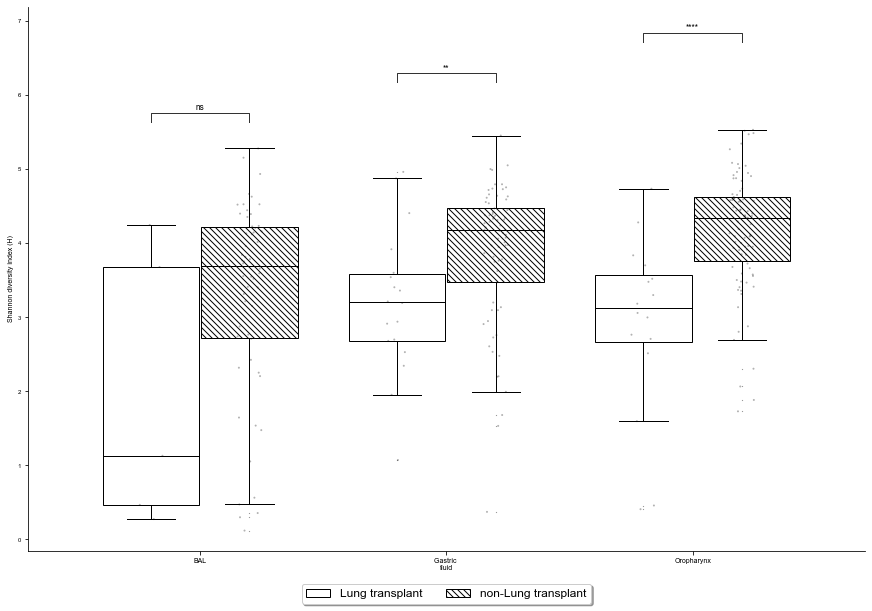

In [10]:
# Plot 
fig, ax = plt.subplots(figsize=(15,10))

color_dict = {'Other':'white', 'Lung Transplant':'white'}

x="Swab_site"
y="Shannon diversity index (H)"
hue='LT_plot'
hue_order=['Lung Transplant','Other']
order = ['lung', 'stomach', 'throat']
data = shannon_meta_LST

ax = sns.boxplot(x=x, y=y, hue=hue,
                data=data, hue_order=hue_order, palette=color_dict, order=order, linewidth=1, fliersize=0.4)
sns.stripplot(x=x, y=y, hue=hue,
                data=data, dodge=True, linewidth=0,palette = ['k', 'k', 'k'], hue_order=hue_order, order=order, alpha=0.3, s= 2)

ax.set_xticklabels(['BAL', 'Gastric \nfluid', 'Oropharynx'], fontsize=7)
ax.set_xlabel('')
ax.set_ylabel('Shannon diversity index (H)', fontsize=7)
ax.tick_params(axis='y', labelsize=6)

# For statistical annotation
boxPairList_CF = [(('lung', 'Lung Transplant'), ('lung', 'Other')),
                 (('stomach', 'Lung Transplant'), ('stomach', 'Other')),
                 (('throat', 'Lung Transplant'), ('throat', 'Other'))]

add_stat_annotation(ax, data=data, x=x, y=y, order=order, hue=hue, hue_order=hue_order,
                    box_pairs=boxPairList_CF,
                    test='Wilcoxon', text_format='star', loc='inside', verbose=2, linewidth=1, fontsize='small')

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_color('k')
ax.spines['left'].set_color('k')

hatch = r'\\\\'
# Add patterns to distinuigh boxes
for i,thisbox in enumerate(ax.artists):
    # Set a different hatch for each bar
    thisbox.set_edgecolor('black')
    if i in [1, 3, 5]:
        thisbox.set_hatch(hatch)
        
    # iterate over whiskers and median lines
    for j in range(6*i,6*(i+1)):
         ax.lines[j].set_color('black')

# Legend
handles, labels = ax.get_legend_handles_labels()
labels2 = ['Lung transplant', 'non-Lung transplant']
handles2 = handles[0:2]

LT_patch = mpatches.Patch( facecolor=color_dict[labels[0]],label=labels2[0], edgecolor='k')
nonLT_patch= mpatches.Patch( facecolor=color_dict[labels[1]],hatch=hatch,label=labels2[1], edgecolor='k')

ax.legend(handles = [LT_patch, nonLT_patch],loc='upper center', bbox_to_anchor=(0.5, -0.05),
          fancybox=True, shadow=True, ncol=2, fontsize=12)

# Hide grid lines
ax.grid(False)

plt.show()
